<h1>Kreiranje tagera za srpski jezik pomoću NLTK alata</h1>

U 2019. godini objavljeni su značajni radovi u oblasti obrade prirodnih jezika. Na osnovu jezičkog modela BERT čiji je tvorac kompanija Google, napravljene su varijante poput DistilBERT, RoBERTa, AlBERT, XLNet i drugi, koji dostižu visoke rezultate u raznim zadacima obrade prirodnog jezika. Primjene su sve šire, algoritmi kompleksniji. Ispod ovog visoko apstraktnog nivoa, može se naći ograničen skup zadataka koji i dalje predstavljaju izazov za istraživače. Mala poboljšanja u osnovnim zadacima poput tagiranja direktno i višestruko utiču na zadatke koji stoje kasnije u sekvenci obrade (eng. pipeline).

<h2>Tagiranje</h2>

Tagiranje (ili etiketiranje) je proces dodjele oznake (tag, etiketa) svakom tokenu u određenom tekstu. Prema tipu taga koji se dodjeljuje, tagiranje može imati razne primjene. U osnovnoj varijanti, tagiranje podrazumijeva određivanje vrste riječi u rečenici (eng. POS tagging). 

Program koji vrši tagiranje naziva se tager. Ovakvi programi mogu biti kreirani na brojne načine, a u ovom radu će biti govoreno o primjeni NLTK alata u kreiranju tagera.

<h3>Automatsko tagiranje pomoću NLTK platforme</h3>

NLTK je biblioteka napisana u programskom jeziku Pajton. Pored toga što sadrži više od 50 korpusa i jezičkih resursa, koristi se za pravljenje programa za rad nad podacima generisanim ljudskim jezikom. Ovakvi programi imaju primjene u klasifikaciji, tokenizaciji, stemovanju, tagiranju, parsiranju i semantičkom odlučivanju.

Automatsko tagiranje podrazumijeva dodjelu taga svakom tokenu u nepoznatom tekstu jednostavnim pokretanjem tagera.

In [1]:
import nltk
text = nltk.word_tokenize("Today we're going to build a tagger for Serbian language.")
nltk.pos_tag(text, tagset="universal")

[('Today', 'NOUN'),
 ('we', 'PRON'),
 ("'re", 'VERB'),
 ('going', 'VERB'),
 ('to', 'PRT'),
 ('build', 'VERB'),
 ('a', 'DET'),
 ('tagger', 'NOUN'),
 ('for', 'ADP'),
 ('Serbian', 'ADJ'),
 ('language', 'NOUN'),
 ('.', '.')]

Svakom tokenu je ispravno dodjeljena vrsta riječi osim u slučaju "today" (prilog). Ovo je zapravo jedan od rijetkih slučajeva da je podrazumijevani tager pogriješio. Pogledajmo kako ovaj tager radi na sprskom jeziku:

In [2]:
text = nltk.word_tokenize("Možeš li da pogodiš vrstu riječi u rečenici?")
nltk.pos_tag(text, tagset="universal")

[('Možeš', 'NOUN'),
 ('li', 'VERB'),
 ('da', 'NOUN'),
 ('pogodiš', 'NOUN'),
 ('vrstu', 'NOUN'),
 ('riječi', 'NOUN'),
 ('u', 'ADJ'),
 ('rečenici', 'NOUN'),
 ('?', '.')]

Primjećuje se da je tager u skoro svim slučajevima pogriješio. Ugrađeni tager nije primjenljiv na srpski jezik. U narednim koracima donijećemo postupnu implementaciju tagera za srpski jezik.

<h3>1. Učitavanje podataka</h3>

Da bi se uopšte sproveo proces tagiranja, neophodno je da se izvrši proces tokenizacije, tj. da se ulazni tekst podijeli na tokene. Ovaj proces nije trivijalan te se njime nećemo baviti u ovom radu.

In [3]:
from pathlib import Path
input_data = Path('tagged-data-original.txt').read_text(encoding="utf-8-sig").strip().splitlines()

In [4]:
input_data[:4]

['1\tJaroslav\tN:m\tPROPN\tJaroslav',
 '1\tHašek\tN:m\tPROPN\tHašek',
 '1\t:\tPUNCT\tPUNCT\t:',
 '1\tDOŽIVLJAJI\tN:m\tNOUN\tdoživljaj']

In [18]:
input_tagged_tokens = [(tt.split()[1], tt.split()[2]) for tt in input_data]
input_tagged_tokens[:4]

[('Jaroslav', 'N:m'), ('Hašek', 'N:m'), (':', 'PUNCT'), ('DOŽIVLJAJI', 'N:m')]

In [19]:
input_tokens = [token for (token, tag) in input_tagged_tokens]
input_tokens[:4]

['Jaroslav', 'Hašek', ':', 'DOŽIVLJAJI']

In [20]:
len(input_tagged_tokens)

199646

In [21]:
# Unique tokens
len(list(set(input_tokens)))

31139

Učitali smo tekst podijeljen na tokene i njihove tagove. Međutim, za stvaranje tagera, potrebno je izvršiti podjelu na rečenice.

In [24]:
input_tagged_sents = []
last_sentence = []

last_sentence_number = 1
for idx in range(len(input_data)):  # iterate through every word
    parts = input_data[idx].split()
    sentence_number = int(parts[0]) # 1
    token = parts[1] # Jaroslav
    tag = parts[2] # PROPN
  
    if sentence_number != last_sentence_number:        # if this is the end of the sentence, finalize it and build a new one
        last_sentence_number = sentence_number
        input_tagged_sents.append(last_sentence)
        last_sentence = []    

    last_sentence.append((token, tag)) # always add the current token to the last sentence

# add the last sentence
input_tagged_sents.append(last_sentence)

len(input_tagged_sents)

10890

In [25]:
print(input_tagged_sents[:2])

[[('Jaroslav', 'N:m'), ('Hašek', 'N:m'), (':', 'PUNCT'), ('DOŽIVLJAJI', 'N:m'), ('DOBROG', 'A:am'), ('VOJNIKA', 'N:m'), ('ŠVEJKA', 'N:m'), ('u', 'PREP'), ('prvom', 'A:an'), ('svetskom', 'A:an'), ('ratu', 'N:m'), (';', 'SENT')], [('preveo', 'V:m'), ('STANISLAV', 'N:m'), ('VINAVER', 'N:m'), ('Veliko', 'A:an'), ('doba', 'N:n'), ('traži', 'V'), ('velike', 'A:af'), ('ljude', 'N:m'), ('.', 'SENT')]]


Sada je dobijen tekst podijeljen na rečenice te se može nastaviti sa daljom obradom.

<h3>2. Analiziranje podataka</h3>

In [26]:
import matplotlib

tag_fd = nltk.FreqDist(tag for (token, tag) in input_tagged_tokens)
print(tag_fd.most_common())

[('V', 24260), ('PUNCT', 20911), ('N:m', 19776), ('N:f', 19295), ('PREP', 16542), ('CONJ', 15677), ('PRO', 13842), ('SENT', 10566), ('ADV', 8980), ('A:am', 8184), ('PAR', 7996), ('N:n', 7361), ('A:af', 6305), ('V:m', 5278), ('NUM', 3583), ('A:an', 3506), ('V:f', 2459), ('V:n', 2179), ('ABB', 641), ('N', 485), ('A:bm', 270), ('A:bf', 229), ('X', 224), ('PRO:f', 203), ('PRO:m', 190), ('A:cm', 116), ('INT', 110), ('A', 109), ('PRO:n', 106), ('A:cf', 81), ('A:bn', 73), ('A:cn', 33), ('NUM:m', 29), ('NUM:f', 17), ('A:f', 6), ('PREF', 4), ('A:m', 4), ('N:af', 3), ('NUM:n', 3), ('PRO:an', 2), ('A:n', 2), ('PRO:af', 2), ('PRO:am', 1), ('N:an', 1), ('A:asm', 1), ('A:a', 1)]


Najviše tokena je iz grupe imenica, zatim znakova interpunkcije i glagola. Zapravo, prvih 5 vrsta riječi (već navedene + pridjevi i predlozi) predstavlja 60% svih tagova, što se može vidjeti sa sledećeg dijagrama:

In [27]:
tag_fd.plot(cumulative=True)

<Figure size 640x480 with 1 Axes>

<h3>3. Implementacija tagera</h3>

U ovoj sekciji će biti data implementacija različitih tagera, a onda će se njihovim kombinovanjem dobiti tager od kojeg najviše očekujemo.

Prije toga, neophodno je podijeliti podatke na skup za treniranje i skup za testiranje.

In [28]:
size = int(len(input_tagged_sents) * 0.8)
print(size)

8712


In [29]:
import random
random.shuffle(input_tagged_sents)
train_sents = input_tagged_sents[:size]
test_sents = input_tagged_sents[size:]

<h4>Podrazumijevani tager (eng. Default tagger)</h4>

Ovaj tager je najjednostavniji, ali može da obradi svaku riječ. Ideja koja stoji iza ovog tagera je da je, pošto najviše ima imenica, svaka riječ najvjerovatnije i jesta imenica. Tako i radi - svakoj riječi dodjeljuje tag 'imenica'.
Ovaj tager se ne koristi zasebno, već kao podrška naprednijim tagerima koji ne tagiraju svaku riječ.
Može se reći da, nakon što se iscrpi poznati skup riječi nekog jezika, nove riječi koje budu dolazile su vjerovatno imenice, tako da ovaj tager doprinosi robusnosti sistema.

In [30]:
pos_tag_most_frequent = tag_fd.most_common()[0][0]

In [32]:
default_tagger = nltk.DefaultTagger(pos_tag_most_frequent)

tokens = nltk.word_tokenize("Svaka riječ će dobiti isti tag")
default_tagger.tag(tokens)

[('Svaka', 'V'),
 ('riječ', 'V'),
 ('će', 'V'),
 ('dobiti', 'V'),
 ('isti', 'V'),
 ('tag', 'V')]

Svi tageri imaju veoma korisnu metodu evaluate() koja testira dobijeni tager na već tagiranom skupu riječi i vraća preciznost.

In [33]:
default_tagger.evaluate(input_tagged_sents)

0.12151508169459944

I sa ovako trivijalnim tagerom, uspješno je pogođen svaki peti token.

<h4>Tager regularnim izrazima (eng. RegExp tagger)</h4>

Ideja koja se nadograđuje na tu da svakoj riječi dodijelimo isti token jeste da primjenimo grupu pravila koja će na osnovu oblika riječi donijeti odluku. Jedan takav, veoma ograničeni skup, dat je iznad. Sastoji se iz pravila kao što su: ako se riječ završava na "ki", onda je to pridjev, ako je na "ti" ili "ći", onda je to glagol.

In [34]:
patterns = [
...     (r'.*ki$', 'A'),
...     (r'.*ti$', 'V'),
...     (r'.*ći$', 'V'),
...     (r'^-?[0-9]+(\.[0-9]+)?$', 'NUM'),   # cardinal numbers
...     (r'.*', 'V')                      # nouns (default)
... ]

In [35]:
regexp_tagger = nltk.RegexpTagger(patterns)
regexp_tagger.evaluate(input_tagged_sents)

0.13063622612023282

Sa ovim skupom pravila, uspješnost tagiranja se povećala u odnosu na podrazumijevani tager, ali samo za 2 procenta. Sa boljim skupom pravila tačnost bi bila veća ali samo do određene granice.

<h4>Tager prepoznavanjem (eng. Lookup tagger)</h4>

Većina riječi koja se često pojavljuje nisu imenice. Potražićemo 100 riječi koje se najčešće pojavljuju i zapamtiti njihov najčešći tag.

In [20]:
fd = nltk.FreqDist(input_tokens)
cfd = nltk.ConditionalFreqDist(input_tagged_tokens)
most_freq_tokens = fd.most_common(100)
likely_tags = dict((token,cfd[token].max()) for (token,_) in most_freq_tokens)
baseline_tagger = nltk.UnigramTagger(model=likely_tags)
baseline_tagger.evaluate(input_tagged_sents)

0.43305651002274026

Sa samo 100 memorisanih riječi i njihovih tagova, ovaj tager je uspio da pogodi skoro svaki drugi tag.

In [21]:
text = nltk.word_tokenize("Danas je lijep i sunčan dan")
baseline_tagger.tag(text)

[('Danas', None),
 ('je', 'AUX'),
 ('lijep', None),
 ('i', 'CCONJ'),
 ('sunčan', None),
 ('dan', None)]

Na nepoznatom tekstu, većina tagova su dodijeljeni kao "None" jer nije prepoznao riječi među odabranih 100. Moguće je da ove tokene prosledimo podrazumijevanom tageru koji će znati da ih obradi.

In [22]:
baseline_tagger = nltk.UnigramTagger(model=likely_tags, backoff=nltk.DefaultTagger(pos_tag_noun))
baseline_tagger.evaluate(input_tagged_sents)

0.6373130440880358

In [23]:
def performance(cfd, tokenlist):
    lt = dict((token, cfd[token].max()) for token in tokenlist)
    baseline_tagger = nltk.UnigramTagger(model=lt, backoff=nltk.DefaultTagger(pos_tag_noun))
    return baseline_tagger.evaluate(input_tagged_sents)

def display():
    import pylab
    token_freqs = nltk.FreqDist(input_tokens).most_common()
    tokens_by_freq = [w for (w, _) in token_freqs]
    cfd = nltk.ConditionalFreqDist(input_tagged_tokens)
    sizes = 2 ** pylab.arange(15)
    perfs = [performance(cfd, tokens_by_freq[:size]) for size in sizes]
    pylab.plot(sizes, perfs, '-bo')
    # pylab.title('Performanse tagera prepoznavanjem u odnosu na model promjenljive veličine')
    pylab.xlabel('Number of the stored tags')
    pylab.ylabel('Accuracy')
    pylab.show()

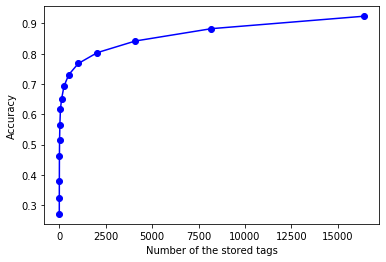

In [24]:
display()

<h4>Unigram tager</h4>

Ako se tager prepoznavanjem proširi da obuhvata sve riječi i ako se proces pronalaženja najčešćih riječi i njihovih najvjerovatnijih tagova zamijeni treniranjem, dobiće se Unigram tager. Dakle, zasnovan je na jednostavnom statističkom algoritmu: za svaku riječ predložiće njen najvjerovatniji tag, iako ta riječ može imati više tagova.

In [25]:
unigram_tagger = nltk.UnigramTagger(train_sents)
unigram_tagger.evaluate(test_sents)

0.8678468404053354

Unigram tager očekivano daje bolje rezultate od tagera prepoznavanjem, ali i dalje analizira riječ po riječ.

<h4>N-gram tager</h4>

Uopštavanjem Unigram tagera gdje se analizira i kontekst riječi, a ne samo ta riječ dobija se N-gram tager. U zavisnosti od broja riječi koje prethode riječi za koju se traži tag, dobijamo Bigram, Trigram tagere itd.

In [26]:
t2 = nltk.BigramTagger(train_sents)
t2.tag(nltk.word_tokenize("Danas je lijep i sunčan dan."))

[('Danas', 'ADV'),
 ('je', 'AUX'),
 ('lijep', None),
 ('i', None),
 ('sunčan', None),
 ('dan', None),
 ('.', None)]

Prve dvije riječi su korektno tagirane. Međutim, za ostatak riječi tager nije mogao da nađe kombinacije u trening skupu pa ih je zato označio kao 'None'.

<h4>Kombinovani tager</h4>

N-gram tageri nisu uspješni u svim situacijama, te je potrebno pozvati u pomoć tagere koji znaju da rade nad manjim, neviđenim sekvencama.

In [27]:
t0 = nltk.DefaultTagger(pos_tag_noun)
print("t0: ", t0.evaluate(test_sents))
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
print("t1: ", t1.evaluate(test_sents))
t2 = nltk.BigramTagger(train_sents, backoff=t1)
print("t2: ", t2.evaluate(test_sents))
t3 = nltk.TrigramTagger(train_sents, backoff=t2)
print("t3: ", t3.evaluate(test_sents))

t0:  0.21400922113464335
t1:  0.9031287753642842
t2:  0.9050518997016692
t3:  0.9051505214625607


Može se primjetiti da je dodavanjem Bigram i Trigram tagera čak došlo do smanjenja ukupne tačnosti. To obrazlažemo time što u srpskom jeziku red riječi nije striktno određen. Moguće je da bi ovaj tager doprinio više pri većem trening skupu.

<h4>Afiksni tager</h4>

Od sekvencijalnih tagera u NLTK alatu postoji još i afiksni tager. Ovaj tager određuje tag tokena prema prefiksu ili sufikse fiksne, konfigurabilne dužine.

In [28]:
at = nltk.AffixTagger(train_sents, backoff=t1)
at.evaluate(test_sents)

0.8845632288764516

Postoje i nestandardni tageri, koji su vremenom ugrađivani pod uticajem eskternih saradnika, u zasebne potpakete.

<h4>CRF tager</h4>

Ovaj tager se zasniva na uslovnim nasumičnim poljima (eng. [Conditional Random Fields](https://en.wikipedia.org/wiki/Conditional_random_field)).

In [29]:
crft = nltk.tag.CRFTagger()
crft.train(train_sents,'model.crf.tagger')

crft.evaluate(test_sents)

0.9334549668384329

<h4>HMM tager</h4>

Ovaj tager se zasniva na skrivenim Markovljevim modelima (eng. [Hidden Markov Models](https://sr.wikipedia.org/wiki/Skriveni_Markovljev_model)). 

In [30]:
hmmt = nltk.tag.hmm.HiddenMarkovModelTrainer().train_supervised(train_sents)

hmmt.evaluate(test_sents)

0.47760053255750884

<h4>Perceptron tager</h4>

Ovaj tager se zasniva na uprosječenoj jednoslojnoj neuralnoj mreži.

In [31]:
pt = nltk.tag.perceptron.PerceptronTagger(load=False)
pt.train(train_sents)

pt.evaluate(test_sents)

0.9499248009073202

<h4>TnT tager</h4>

TnT je skraćenica od engleske riječi *Trigrams'n'Tags* i predstavlja statistički tager zasnovan na drugorazrednim Markovljevim modelima. Optimizovan je za brzinu rada. Više se može naći u [originalnoj implementaciji](http://www.coli.uni-saarland.de/~thorsten/tnt/).

In [32]:
tntt = nltk.tag.tnt.TnT(unk=t1, Trained=True)
tntt.train(train_sents)

tntt.evaluate(test_sents)

0.9055450085061268

<h4>Brilov tager</h4>

Brilovi tageri polaze od datog tagera te na osnovu odabranog skupa pravila transformišu incijalno zadate tokene. Postoji više predefinisanih skupova pravila.

In [33]:
nltk.tag.brill.describe_template_sets()

brill24 
    Return 24 templates of the seminal TBL paper, Brill (1995)
     

fntbl37 
    Return 37 templates taken from the postagging task of the
    fntbl distribution http://www.cs.jhu.edu/~rflorian/fntbl/
    (37 is after excluding a handful which do not condition on Pos[0];
    fntbl can do that but the current nltk implementation cannot.)
     

nltkdemo18 
    Return 18 templates, from the original nltk demo, in multi-feature syntax
     

nltkdemo18plus 
    Return 18 templates, from the original nltk demo, and additionally a few
    multi-feature ones (the motivation is easy comparison with nltkdemo18)
     



Sortirani po performansama, od najboljeg do najlošijeg skupa pravila, pokazali su se: brill24, fntbl37, nltkdemo18plus, nltkdemo18.

In [34]:
bt0 = nltk.tag.brill_trainer.BrillTaggerTrainer(t0, nltk.tag.brill.brill24()).train(train_sents)
print("BRILL + DEFAULT: ", bt0.evaluate(test_sents))
bt1 = nltk.tag.brill_trainer.BrillTaggerTrainer(t1, nltk.tag.brill.brill24()).train(train_sents)
print("BRILL + UNIGRAM: ", bt1.evaluate(test_sents))
bt2 = nltk.tag.brill_trainer.BrillTaggerTrainer(t2, nltk.tag.brill.brill24()).train(train_sents)
print("BRILL + BIGRAM: ", bt2.evaluate(test_sents))

BRILL + DEFAULT:  0.6800710076678419
BRILL + UNIGRAM:  0.9064079489139278
BRILL + BIGRAM:  0.905939495549693


<h5>Varijante Brilovog tagera nad ostalim tagerima</h5>

In [35]:
bcrft = nltk.tag.brill_trainer.BrillTaggerTrainer(crft, nltk.tag.brill.brill24()).train(train_sents)
print("Brill + CRF: ", bcrft.evaluate(test_sents))

Brill + CRF:  0.9376710471165463


In [36]:
bhmmt = nltk.tag.brill_trainer.BrillTaggerTrainer(hmmt, nltk.tag.brill.brill24()).train(train_sents)
print("Brill + HMM: ", bhmmt.evaluate(test_sents))

Brill + HMM:  0.4788086491284302


In [37]:
bpt = nltk.tag.brill_trainer.BrillTaggerTrainer(pt, nltk.tag.brill.brill24()).train(train_sents)
print("BRILL + PERCEPTRON: ", bpt.evaluate(test_sents))

BRILL + PERCEPTRON:  0.9501220444291033


In [38]:
#btntt = nltk.tag.brill_trainer.BrillTaggerTrainer(tntt, nltk.tag.brill.brill24()).train(train_sents)
#print("BRILL + TNT: ", btntt.evaluate(test_sents))

In [39]:
bat = nltk.tag.brill_trainer.BrillTaggerTrainer(at, nltk.tag.brill.brill24()).train(train_sents)
print("BRILL + AFFIX: ", bat.evaluate(test_sents)) 

BRILL + AFFIX:  0.9066791587563796


<h3>Čuvanje tagera</h3>

Treniranje na većim korpusima može zahtijevati značajne resurse, te je korisno rezultate čuvati za sledeću upotrebu. Standard za ovu upotrebu u jeziku Pajton je biblioteka "Pickle".

In [40]:
from pickle import dump
output = open('t2.pkl','wb')
dump(t2, output, -1)
output.close()

Ovaj objekat se kasnije može učitati i ponovno koristiti za tagiranje, npr:

In [41]:
from pickle import load
input = open('t2.pkl','rb')
t2 = load(input)
input.close()

In [42]:
text = nltk.word_tokenize("Danas je lijep i sunčan dan")
t2.tag(text)

[('Danas', 'ADV'),
 ('je', 'AUX'),
 ('lijep', 'NOUN'),
 ('i', 'CCONJ'),
 ('sunčan', 'NOUN'),
 ('dan', 'NOUN')]